<b>Concept</b>
<br>https://medium.com/@philippetousignant/dynamic-factor-models-in-python-58d2d5252640
<br>https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp1564.pdf
<br>
<br><b>Statsmodels Dynamic Factor Month-Quarter</b>
<br>Documentation: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html
<br>Source code: https://www.statsmodels.org/stable/_modules/statsmodels/tsa/statespace/dynamic_factor_mq.html
<br>.apply() method: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.apply.html#statsmodels.tsa.statespace.mlemodel.MLEResults.apply

In [1]:
import datetime
import json
import pandas as pd
import numpy as np
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

Static data

In [2]:
files = {'sources':'Data Sources.csv',
         'data':'Data Cleaned.json',
         'final':'Classical Statistics Model Predictions.csv'}

In [3]:
train_dates = {'start':'1991-01-01', 'end':'2017-12-31'}
factors = (1,8)
lags = (1,2)
ar_range = (1,8)

In [4]:
ics = ['aic','bic','hqic']

Classes and functions

In [5]:
class Variables:
    def __init__(self, df):
        self.dep = df[df['Dependent']=='Y']['Name'].tolist()[0]

        self.indep = df[df['Dependent']!='Y']['Name'].tolist()
        self.indep_exclude = ['business expectation']
        self.indep = [i for i in self.indep if all(j not in i.lower() for j in self.indep_exclude)]

        self.freq = dict(zip(df['Name'],df['Frequency']))

        self.non_stat = []

In [6]:
def run_df(data, no_factors, f_lags):
    try:
        model = sm.DynamicFactorMQ(endog=data,
                                   k_endog_monthly=len([k for k,v in variables.freq.items() if v=='M']),
                                   factors=no_factors,
                                   factor_orders=f_lags,
                                   freq='M',
                                   idiosyncratic_ar1=True)
        results = model.fit(maxiter=500, disp=False)
        return(model, results)

    except UserWarning:
        print('-model did not converge-', end=' ')
        return(None)

In [7]:
def find_min_ic(models_dict):
    # info criterion type: (model specifications, info criterion value)
    ic_min = {ic:(None,float('inf')) for ic in ics}

    # k: model specifications, v: model object
    for k,v in models_dict.items():
        for ic,val in ic_min.items():
            if v[ic]<ic_min[ic][1]:
                ic_min[ic] = (k,v[ic])
    return(ic_min)

In [8]:
def compare(actual_df, predict_df):
    compare_df = pd.DataFrame(actual_df[variables.dep].dropna().values,
                              index=actual_df[variables.dep].dropna().index,
                              columns=['Actual'])

    compare_df = compare_df.merge(predict_df[[variables.dep]].rename(columns={variables.dep:'Predicted'}),
                                  how='left', left_index=True, right_index=True)
    return(compare_df)

Load raw data

In [9]:
sources = pd.read_csv(files['sources'], encoding='utf-8')
variables = Variables(sources)

In [10]:
with open(files['data']) as f:
    ts_data = json.load(f)

Convert json data to pandas series to check for unit roots and to resample

In [11]:
ts_pd = {}
for series in ts_data:

    if variables.freq[series]=='Q':
        periods = [p.split()[0]+p.split()[-1][::-1] for p in ts_data[series]]
        periods = pd.PeriodIndex(periods, freq=variables.freq[series])
        ts_pd[series] = pd.Series(ts_data[series].values(), index=periods)

    elif variables.freq[series]=='M':
        # warning: pd version 2.0.0 has deprecated kwarg infer_datetime_format
        periods = pd.to_datetime(list(ts_data[series]),infer_datetime_format=True) + pd.tseries.offsets.MonthEnd(0)
        periods = periods.date
        ts_pd[series] = pd.Series(ts_data[series].values(), index=periods)

    elif variables.freq[series]=='D':
        periods = pd.to_datetime(list(ts_data[series])).date
        periods = pd.PeriodIndex(periods, freq=variables.freq[series])
        ts_pd[series] = pd.Series(ts_data[series].values(), index=periods).resample('M').last()
        variables.freq[series] = 'M' # update to 'M' since resampled

    # start all series from first valid index
    ts_pd[series] = ts_pd[series].sort_index()
    ts_pd[series] = ts_pd[series][ts_pd[series].first_valid_index():]

In [12]:
# if p-value >0.05, variable is non-stationary
for i in [j for j in variables.indep if j in ts_pd]:
    print(i)
    p = 12 if variables.freq[i]=='M' else 4

    # if unit root, take % yoy growth (which also removes seasonality)
    if adfuller(ts_pd[i])[1]>0.05:

        if 'sora' in i.lower():
            ts_pd[i] = ts_pd[i].diff(periods=p)
        else:
            ts_pd[i] = ts_pd[i].pct_change(periods=p)

        ts_pd[i] = ts_pd[i][ts_pd[i].first_valid_index():]
        print('Non-stationary', end='\n\n')
        variables.non_stat.append(i)

    # normalise series anyway if series is too large numerically
    elif abs(ts_pd[i]).mean()>1:
        ts_pd[i] = ts_pd[i].pct_change(periods=p)
        print('Stationary, but normalise', end='\n\n')

    else:
        print('Stationary', end='\n\n')

Composite Leading Index (2015 = 100) | Quarterly Composite Leading Index
Non-stationary

Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total
Non-stationary

Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total
Non-stationary

Business Receipts Index For Services Industries, (2014=100) | Total Services
Non-stationary

Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total
Stationary, but normalise

Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total
Non-stationary

Tourism Receipts By Major Components (Year-To-Date) | Tourism Receipts
Stationary, but normalise

Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units)
Non-stationary

Air Cargo Tonnage | Total Direct Tonnage (Tonne)
Stationary, but normalise

Domestic Exports By Commodity Division | Total Domestic Exports
Non-stationary

Merchandise Imports By Commodity Division | Total Merchan

In [13]:
# resample all series to monthly and start from first valid index
for series,freq in {k:v for k,v in variables.freq.items() if k in ts_pd}.items():

    if freq=='Q':
        ts_pd[series] = ts_pd[series].resample('M', convention='end').asfreq()

    try:
        ts_pd[series].index = ts_pd[series].index.to_timestamp() + pd.offsets.MonthEnd(0)
    except:
        pass

    ts_pd[series].index = ts_pd[series].index + pd.offsets.MonthEnd(0)

Convert pd series dictionary to dataframe

Column order adhered to as defined by statsmodels docs for dynamic factor modelling
<br>https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html
- dependent variable leftmost
- monthly data in the first columns
- quarterly data in the last columns

In [14]:
# pass all series into dataframe, start dataframe from first year of GDP growth data
ts_df = pd.DataFrame(ts_pd)
ts_df = ts_df.loc[ts_df.index.year>=ts_df.loc[:,variables.dep].first_valid_index().year]

# rearrange columns in correct order for factor modelling as explained in markdown above
ts_df = ts_df[[variables.dep]+\
              [k for k,v in variables.freq.items() if v=='M' and k!=variables.dep and k in list(ts_df)]+\
              [k for k,v in variables.freq.items() if v=='Q' and k!=variables.dep and k in list(ts_df)]]

ts_df.index.name = 'Period'
ts_df

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total","Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total",Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units),Air Cargo Tonnage | Total Direct Tonnage (Tonne),Domestic Exports By Commodity Division | Total Domestic Exports,Merchandise Imports By Commodity Division | Total Merchandise Imports,Straits Times Index (STI),M1 Money Supply,Index Of Industrial Production (2019 = 100) | Total,...,"Business Expectations For The Services Sector - Operating Receipts Forecast For The Next Quarter, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Business Receipts Index For Services Industries, (2014=100) | Total Services",Tourism Receipts By Major Components (Year-To-Date) | Tourism Receipts,Average Monthly Nominal Earnings Per Employee | Overall Economy,Job Vacancies By Industry And Occupational Group (SSIC 2020) (End Of Period) | Total,Unemployment Rate (End Of Period) | Total Unemployment Rate,Government Operating Expenditure By Sector | Total Government Operating Expenditure
Period,,,,,,,,,,,,,,,,,,,,,
1976-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-31,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,NaN,0.142428,0.086426,-0.055952,-0.073218,-0.079687,-0.047103,0.006289,-0.141464,-0.096117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,0.4,0.110379,0.024854,0.079625,-0.054856,-0.066576,-0.109548,-0.043896,-0.138524,-0.037826,...,5.0,4.0,0.103262,-0.011873,0.079147,NaN,0.05722,NaN,-0.2,NaN
2023-04-30,NaN,NaN,NaN,0.073208,-0.134794,-0.153432,-0.195390,-0.025735,-0.134602,-0.068571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Explore data

In [15]:
ts_df.describe().round(3)

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total","Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total",Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units),Air Cargo Tonnage | Total Direct Tonnage (Tonne),Domestic Exports By Commodity Division | Total Domestic Exports,Merchandise Imports By Commodity Division | Total Merchandise Imports,Straits Times Index (STI),M1 Money Supply,Index Of Industrial Production (2019 = 100) | Total,...,"Business Expectations For The Services Sector - Operating Receipts Forecast For The Next Quarter, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Business Receipts Index For Services Industries, (2014=100) | Total Services",Tourism Receipts By Major Components (Year-To-Date) | Tourism Receipts,Average Monthly Nominal Earnings Per Employee | Overall Economy,Job Vacancies By Industry And Occupational Group (SSIC 2020) (End Of Period) | Total,Unemployment Rate (End Of Period) | Total Unemployment Rate,Government Operating Expenditure By Sector | Total Government Operating Expenditure
count,189.000,447.000,447.000,328.000,268.000,556.000,556.000,415.000,376.000,472.000,...,113.000,113.000,109.000,109.000,81.000,56.000,85.000,128.000,121.000,63.000
mean,6.261,0.012,0.045,0.046,0.008,0.092,0.085,0.062,0.103,0.068,...,5.363,4.912,0.008,0.050,0.059,0.305,0.034,0.079,0.038,0.085
std,4.600,0.099,0.128,0.080,0.115,0.167,0.150,0.245,0.155,0.114,...,14.478,18.897,0.079,0.058,0.065,1.430,0.024,0.323,0.301,0.098
min,-11.900,-0.518,-0.523,-0.203,-0.327,-0.381,-0.335,-0.529,-0.606,-0.322,...,-53.000,-58.000,-0.227,-0.071,-0.139,-0.895,-0.037,-0.652,-0.386,-0.066
25%,3.900,-0.029,-0.029,0.012,-0.053,-0.024,-0.016,-0.085,0.043,-0.003,...,-1.000,-3.000,-0.042,0.011,0.026,-0.094,0.024,-0.104,-0.125,0.023
50%,6.600,0.016,0.027,0.059,0.001,0.095,0.089,0.035,0.093,0.067,...,8.000,7.000,0.010,0.046,0.055,0.024,0.033,0.046,0.000,0.063
75%,9.200,0.051,0.097,0.097,0.061,0.190,0.184,0.182,0.154,0.136,...,13.000,18.000,0.058,0.091,0.094,0.182,0.045,0.223,0.100,0.135
max,18.600,0.695,0.819,0.229,0.420,0.723,0.579,1.472,2.490,0.586,...,30.000,36.000,0.214,0.186,0.187,6.634,0.106,1.192,1.500,0.501


In [16]:
#with plt.rc_context(rc={'figure.max_open_warning':0}):
#    for i in list(ts_df):
#        plt.figure(figsize=(6,4))
#        plt.title('\n'.join('\n'.join(i.split(' | ')).split(' - ')), fontdict={'fontsize':10})
#
#        # fillna because quarterly data has blanks when freq=monthly
#        plt_data = ts_df[[i]].loc[ts_df[[i]].first_valid_index():ts_df[[i]].last_valid_index()].fillna(method='bfill',limit=2)
#
#        plt.plot(plt_data)
#        plt.tight_layout()

Split to train and test datasets

In [17]:
ts_df_train = ts_df[(ts_df.index>=train_dates['start'])&(ts_df.index<=train_dates['end'])]
ts_df_test = ts_df[ts_df.index>train_dates['end']]

Instantiate and fit DF model

In [18]:
# to catch warnings for models that do not converge
warnings.filterwarnings('error', category=UserWarning)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [19]:
dynamic_models = {}
for factor in range(factors[0], factors[1]+1):
    for lag in range(lags[0], lags[1]+1):
        print(f'({factor}, {lag})', end=' ')

        output = run_df(ts_df_train, factor, lag)
        if output:
            dynamic_models[(factor,lag)] = {}
            dynamic_models[(factor,lag)]['model']= output[0]
            dynamic_models[(factor,lag)]['results'] = output[1]

            # extract info criterions
            if dynamic_models[(factor,lag)]['results']:
                for ic in ics:
                    dynamic_models[(factor,lag)][ic] = getattr(dynamic_models[(factor, lag)]['results'], ic)

        print('done')

(1, 1) done
(1, 2) done
(2, 1) done
(2, 2) done
(3, 1) done
(3, 2) done
(4, 1) done
(4, 2) done
(5, 1) done
(5, 2) done
(6, 1) done
(6, 2) -model did not converge- done
(7, 1) done
(7, 2) -model did not converge- done
(8, 1) done
(8, 2) -model did not converge- done


In [20]:
dynamic_models.keys()

dict_keys([(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (4, 1), (4, 2), (5, 1), (5, 2), (6, 1), (7, 1), (8, 1)])

For each information criterion-model pair, run predictions. Then choose model that has lowest RMSE.

In [21]:
dynamic_models_min_ic = find_min_ic(dynamic_models)

(Factors, Lags): (4, 2)
MSE: 3.616
RMSE: 1.902
MAE: 1.464


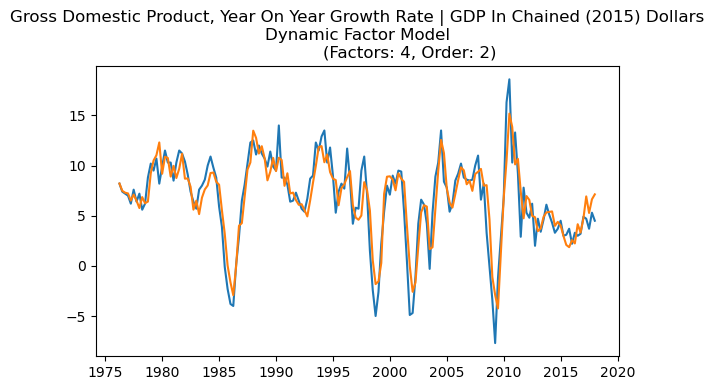

(Factors, Lags): (4, 2)
MSE: 3.616
RMSE: 1.902
MAE: 1.464


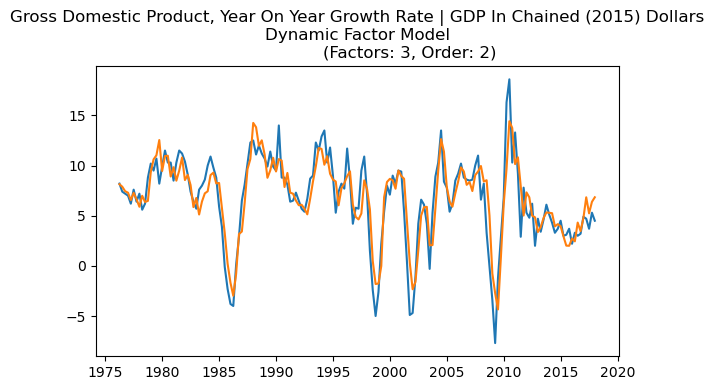

(Factors, Lags): (4, 2)
MSE: 3.616
RMSE: 1.902
MAE: 1.464


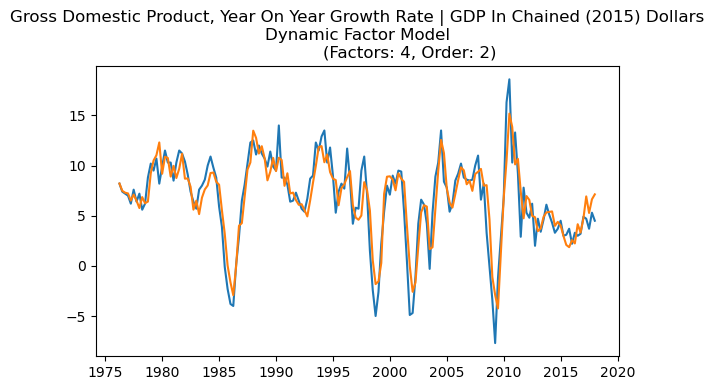

In [22]:
dynamic_best_model = {'(Factors, Lags)':None, 'MSE':np.inf, 'RMSE':np.inf, 'MAE':np.inf}
for i in ics:
    dynamic_compare_df = compare(ts_df_train, dynamic_models[dynamic_models_min_ic[i][0]]['results'].predict())
    mean_sq_err = mse(dynamic_compare_df['Actual'], dynamic_compare_df['Predicted'], squared=True)
    root_mean_sq_err = mse(dynamic_compare_df['Actual'], dynamic_compare_df['Predicted'], squared=False)
    mean_abs_err = mae(dynamic_compare_df['Actual'], dynamic_compare_df['Predicted'])

    # update best model params if error is less than previous
    if mean_sq_err<dynamic_best_model['MSE']:
        dynamic_best_model['(Factors, Lags)'] = dynamic_models_min_ic[i][0]
        dynamic_best_model['MSE'] = mean_sq_err
        dynamic_best_model['RMSE'] = root_mean_sq_err
        dynamic_best_model['MAE'] = mean_abs_err

    print(f"(Factors, Lags): {dynamic_models_min_ic[i][0]}")
    print(f"MSE: {round(mean_sq_err,3)}")
    print(f"RMSE: {round(root_mean_sq_err,3)}")
    print(f"MAE: {round(mean_abs_err,3)}")

    dynamic_compare_df.plot()
    plt.title(label=f"{variables.dep}\nDynamic Factor Model\n\
                    (Factors: {dynamic_models_min_ic[i][0][0]}, Order: {dynamic_models_min_ic[i][0][1]})")
    plt.show()

In [23]:
dynamic_best_model

{'(Factors, Lags)': (4, 2),
 'MSE': 3.616247853373637,
 'RMSE': 1.9016434611602768,
 'MAE': 1.4644905454097916}

In [24]:
# run model on unseen data
try:
    dynamic_forecast = dynamic_models[dynamic_best_model['(Factors, Lags)']]['results']\
                       .apply(ts_df_test, refit=True)
except:
    print('Model did not converge during refit. Params not refitted.')
    dynamic_forecast = dynamic_models[dynamic_best_model['(Factors, Lags)']]['results']\
                       .apply(ts_df_test, refit=False)

dynamic_forecast = compare(ts_df_test, dynamic_forecast.predict())

print('MSE: ', mse(dynamic_forecast['Actual'], dynamic_forecast['Predicted'], squared=True))
print('RMSE: ', mse(dynamic_forecast['Actual'], dynamic_forecast['Predicted'], squared=False))
print('MAE: ', mae(dynamic_forecast['Actual'], dynamic_forecast['Predicted']))

Model did not converge during refit. Params not refitted.
MSE:  157.66275587313703
RMSE:  12.556383072889144
MAE:  7.566003557602502


<Axes: xlabel='Period'>

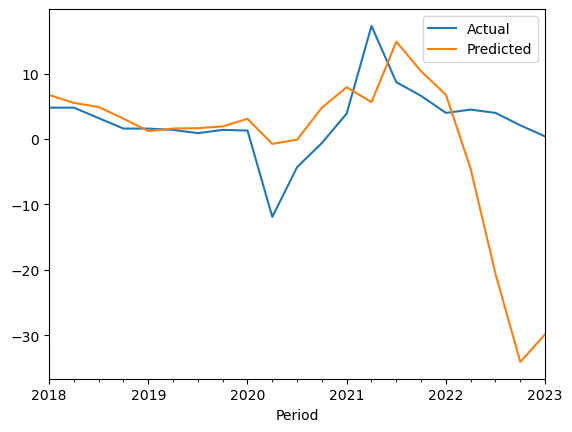

In [25]:
dynamic_forecast.plot()

In [26]:
# append forecasts on unseen to trained predict
dynamic_full = pd.concat([dynamic_compare_df, dynamic_forecast])
dynamic_full = dynamic_full.rename(columns={'Predicted':f"Dynamic Factor {dynamic_best_model['(Factors, Lags)']}"})

Run an AR model as a baseline

In [27]:
ar_df = ts_df[[variables.dep]].dropna()
ar_df_train = ts_df_train[[variables.dep]].dropna()
ar_df_test = ts_df_test[[variables.dep]].dropna()

In [28]:
if adfuller(ar_df[variables.dep])[1]>0.05:
    print(f'[Non-stationary] {variables.dep}')
else:
    print(f'[Stationary] {variables.dep}')

[Stationary] Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars


In [29]:
ar_models = {(p,0,0):None for p in range(ar_range[0], ar_range[1]+1)}

In [30]:
for i in ar_models:
    print(f'{i}', end=' ')
    ar_models[i] = {'model':ARIMA(ar_df_train, order=i).fit()}
    for ic in ics:
        ar_models[i][ic] = getattr(ar_models[i]['model'], ic)
    print('done')

(1, 0, 0) done
(2, 0, 0) done
(3, 0, 0) done
(4, 0, 0) done
(5, 0, 0) done
(6, 0, 0) done
(7, 0, 0) done
(8, 0, 0) done


In [31]:
ar_models_min_ic = find_min_ic(ar_models)
ar_models_min_ic

{'aic': ((7, 0, 0), 739.8553989350705),
 'bic': ((5, 0, 0), 767.9664676565883),
 'hqic': ((7, 0, 0), 751.2661093111924)}

[aic] In-sample MSE of GDP forecast: 4.244


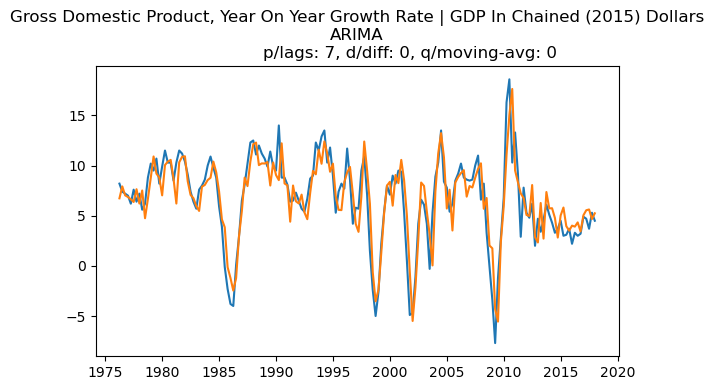

[bic] In-sample MSE of GDP forecast: 4.52


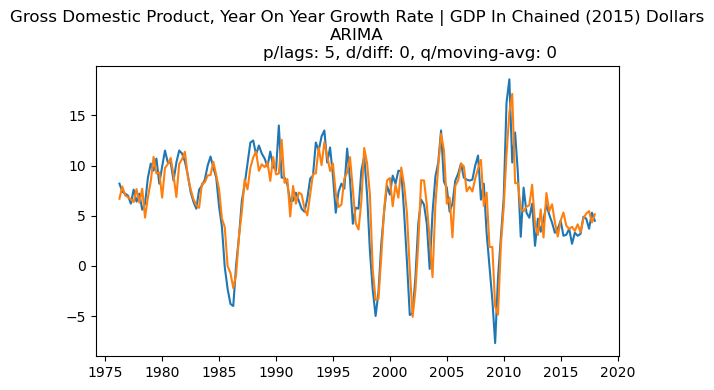

[hqic] In-sample MSE of GDP forecast: 4.244


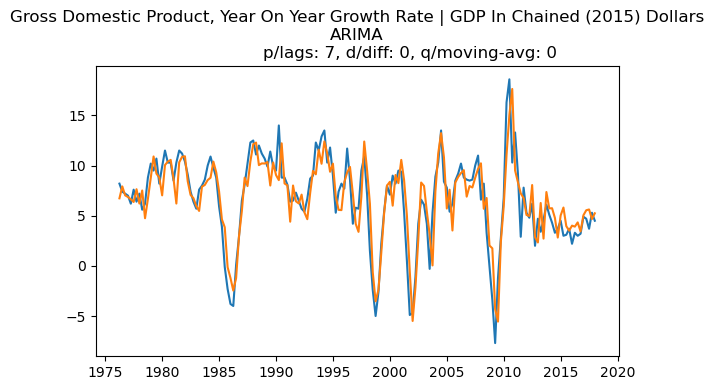

In [32]:
ar_best_model = {'(p/lags, d/diff, q/moving-avg)':None, 'MSE':np.inf, 'RMSE':np.inf, 'MAE':np.inf}
for i in ar_models_min_ic:
    pred_ar = pd.DataFrame(ar_models[ar_models_min_ic[i][0]]['model'].predict())
    pred_ar.columns = [variables.dep]

    ar_compare_df = compare(ts_df_train, pred_ar)
    mean_sq_err = mse(ar_compare_df['Actual'], ar_compare_df['Predicted'], squared=True)
    root_mean_sq_err = mse(ar_compare_df['Actual'], ar_compare_df['Predicted'], squared=False)
    mean_abs_err = mae(ar_compare_df['Actual'], ar_compare_df['Predicted'])

    if mean_sq_err<ar_best_model['MSE']:
        ar_best_model['(p/lags, d/diff, q/moving-avg)'] = ar_models_min_ic[i][0]
        ar_best_model['MSE'] = mean_sq_err
        ar_best_model['RMSE'] = root_mean_sq_err
        ar_best_model['MAE'] = mean_abs_err

    print(f"[{i}] In-sample MSE of GDP forecast: {round(mean_sq_err,3)}")

    ar_compare_df.plot()
    plt.title(label=f"{variables.dep}\nARIMA\n\
                    p/lags: {ar_models_min_ic[i][0][0]}, d/diff: {ar_models_min_ic[i][0][1]}, q/moving-avg: {ar_models_min_ic[i][0][2]}")
    plt.show()

In [33]:
ar_best_model

{'(p/lags, d/diff, q/moving-avg)': (7, 0, 0),
 'MSE': 4.24358206348525,
 'RMSE': 2.059995646472402,
 'MAE': 1.5906521052806544}

In [34]:
ar_df_test

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars"
Period,
2018-03-31,4.8
2018-06-30,4.8
2018-09-30,3.2
2018-12-31,1.6
2019-03-31,1.6
2019-06-30,1.4
2019-09-30,0.9
2019-12-31,1.4
2020-03-31,1.3


In [35]:
# run model on unseen data
ar_forecast = ar_models[ar_best_model['(p/lags, d/diff, q/moving-avg)']]['model'].forecast(steps=len(ar_df_test))
ar_forecast = ar_forecast.reset_index()
ar_forecast.columns = ['Period', variables.dep]
ar_forecast = ar_forecast.set_index(['Period'])
ar_forecast = compare(ar_df_test, ar_forecast)

print('MSE: ', mse(ar_forecast['Actual'], ar_forecast['Predicted'], squared=True))
print('RMSE: ', mse(ar_forecast['Actual'], ar_forecast['Predicted'], squared=False))
print('MAE: ', mae(ar_forecast['Actual'], ar_forecast['Predicted']))

MSE:  46.6224070829499
RMSE:  6.828060272357728
MAE:  5.401128614949308


<Axes: xlabel='Period'>

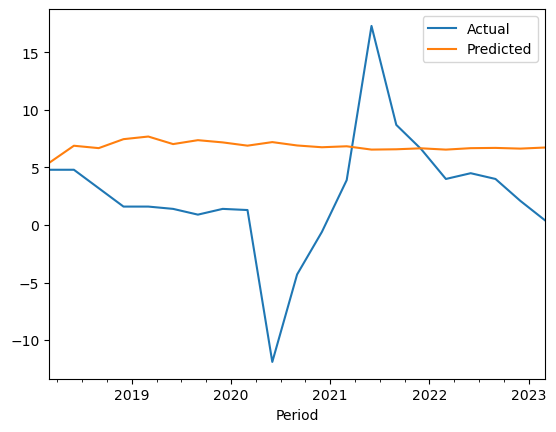

In [36]:
ar_forecast.plot()

In [37]:
# append forecasts on unseen to trained predict
ar_full = pd.concat([ar_compare_df, ar_forecast])
ar_full = ar_full.rename(columns={'Predicted':f"AR {ar_best_model['(p/lags, d/diff, q/moving-avg)']}"})

Export forecasts to csv

In [38]:
export_df = dynamic_full.merge(ar_full.drop(['Actual'],axis=1), left_index=True, right_index=True)
export_df

,Actual,"Dynamic Factor (4, 2)","AR (7, 0, 0)"
Period,,,
1976-03-31,8.2,8.211928,6.733374
1976-06-30,7.4,7.482579,7.924106
1976-09-30,7.2,7.298206,7.029712
1976-12-31,7.0,7.223050,6.862490
1977-03-31,6.2,6.509070,6.640814
...,...,...,...
2022-03-31,4.0,6.779881,6.550752
2022-06-30,4.5,-4.585539,6.676115
2022-09-30,4.0,-20.627660,6.699124


In [39]:
export_df.to_csv(files['final'], encoding='utf-8')